In [ ]:
#!pip install matplotlib.pyplot
#!pip install seaborn
#!pip install pandas
#!pip install numpy
#!pip install geopandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.callbacks import EarlyStopping
import warnings
%matplotlib inline
warnings.simplefilter("ignore")
sns.set(style="darkgrid")

In [ ]:
df = pd.read_csv('cian_parsing_result_sale_1_100_moskva_18_Nov_2023_23_04_31_527788.csv', sep=';')
df.head()

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,district,street,house_number,underground,residential_complex
0,ANT Development,developer,https://www.cian.ru/sale/flat/291563636/,Москва,sale,flat,28,34,2,51.2,954271,48858726,Дорогомилово,Поклонная,9,Парк Победы,Поклонная 9
1,SHOW ME,real_estate_agent,https://www.cian.ru/sale/flat/291778742/,Москва,sale,flat,37,37,-1,135.3,923872,125000000,Хорошевский,Ленинградский проспект,37/6,Аэропорт,Прайм Парк
2,ANT Development,developer,https://www.cian.ru/sale/flat/283856103/,Москва,sale,flat,10,34,3,86.8,1177508,102207781,Дорогомилово,Поклонная,9,Парк Победы,Поклонная 9
3,LaRichesse,real_estate_agent,https://www.cian.ru/sale/flat/281332469/,Москва,sale,flat,5,6,3,111.0,608018,67490000,Беговой,3-я Ямского Поля,9,Белорусская,Art Residence
4,ANT Development,developer,https://www.cian.ru/sale/flat/291385930/,Москва,sale,flat,26,34,4,134.1,966340,129586246,Дорогомилово,Поклонная,9,Парк Победы,Поклонная 9


In [ ]:
df.isnull().sum()

author                   0
author_type              0
link                     0
city                     0
deal_type                0
accommodation_type       0
floor                    0
floors_count             0
rooms_count              0
total_meters             0
price_per_m2             0
price                    0
district                66
street                 138
house_number           159
underground             31
residential_complex    287
dtype: int64

In [ ]:
# df = df.dropna(subset=('residential_complex', 'house_number', 'district', 'street', 'underground'))

In [ ]:
df.isna().sum()

author                 0
author_type            0
link                   0
city                   0
deal_type              0
accommodation_type     0
floor                  0
floors_count           0
rooms_count            0
total_meters           0
price_per_m2           0
price                  0
district               0
street                 0
house_number           0
underground            0
residential_complex    0
dtype: int64

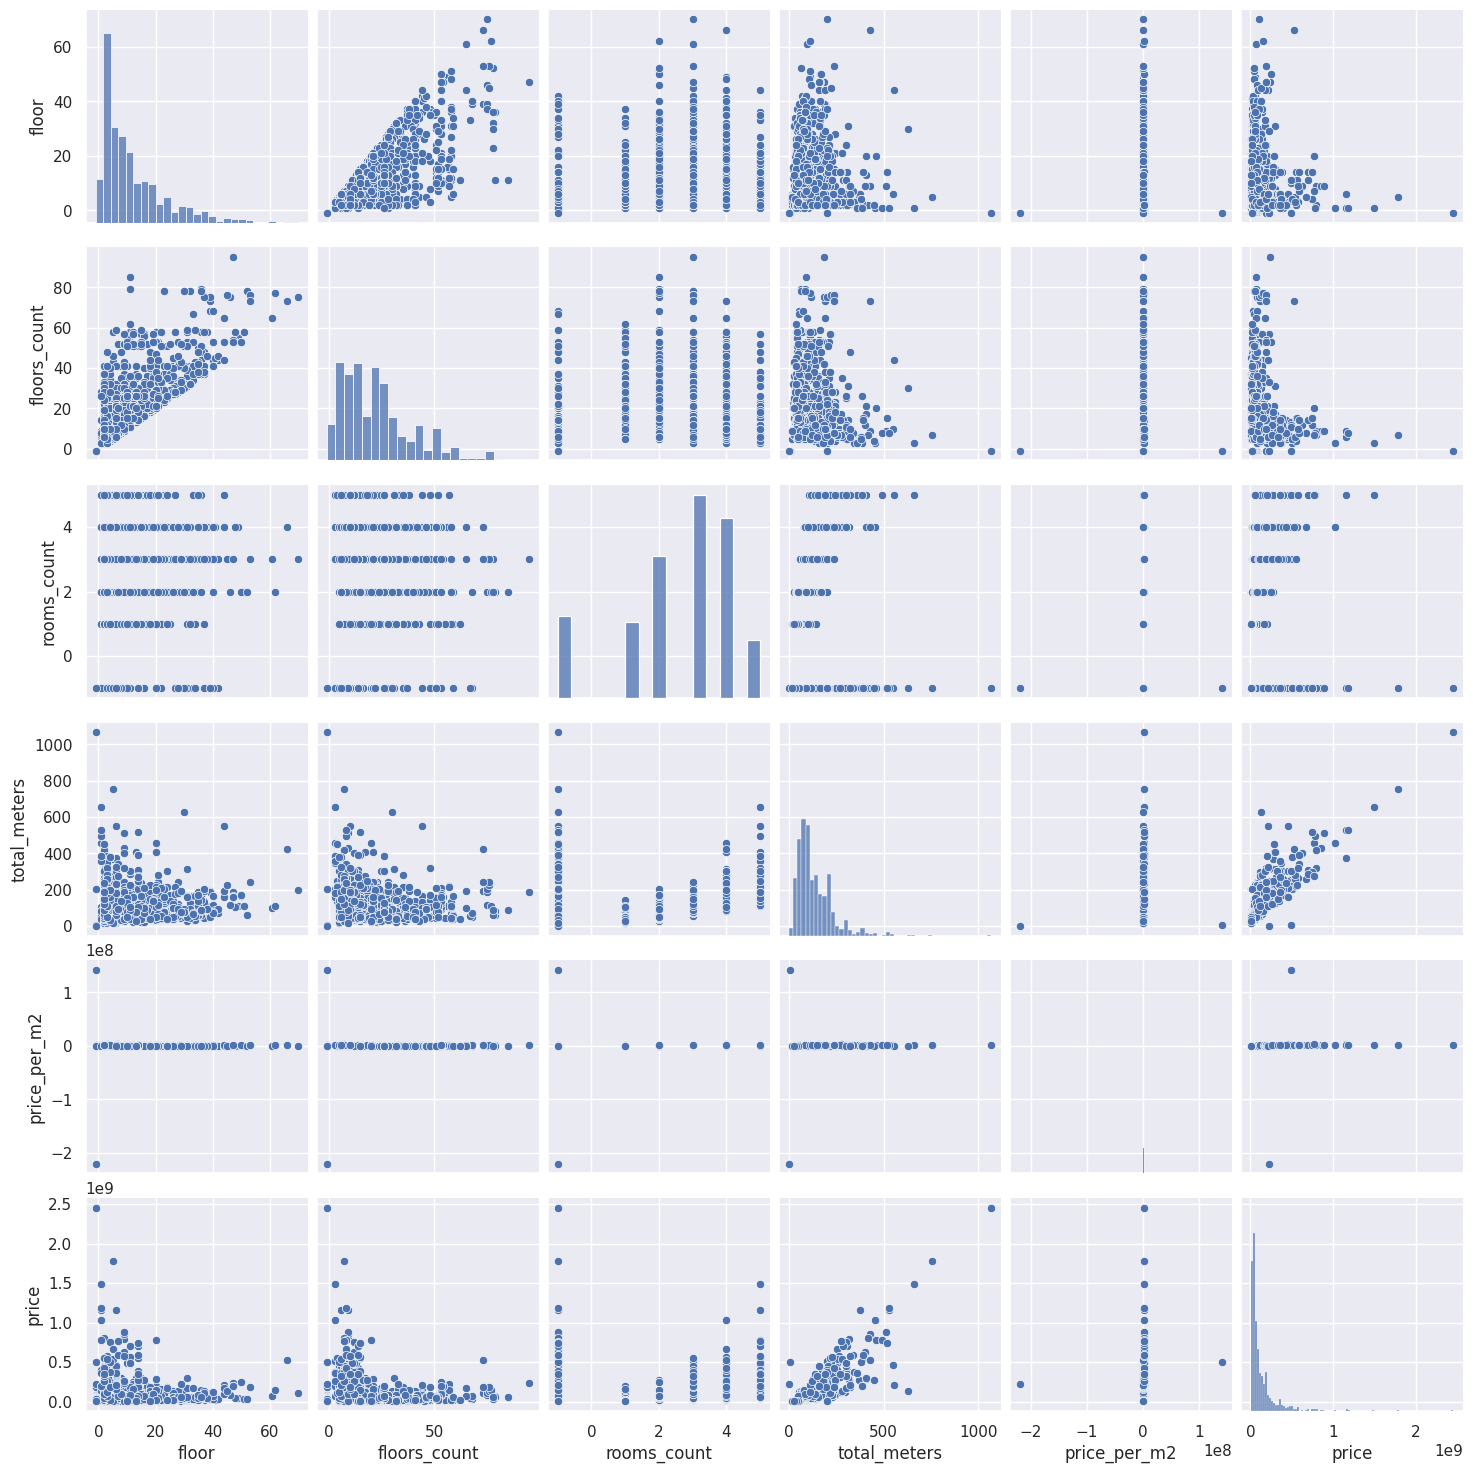

In [ ]:
sns.pairplot(df, palette='flare')

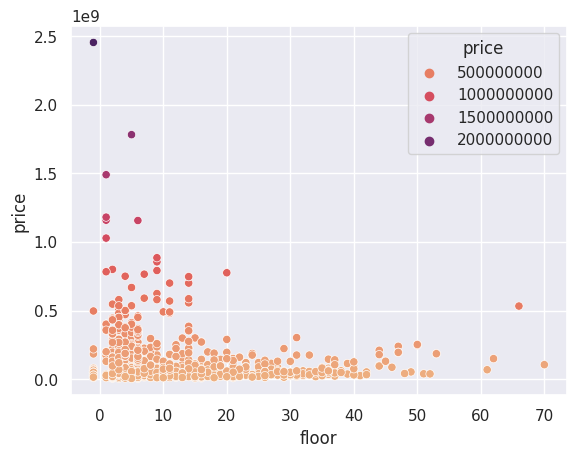

In [ ]:
sns.scatterplot(data=df, x="floor", y="price", hue='price', palette='flare')
plt.title('')
plt.show()

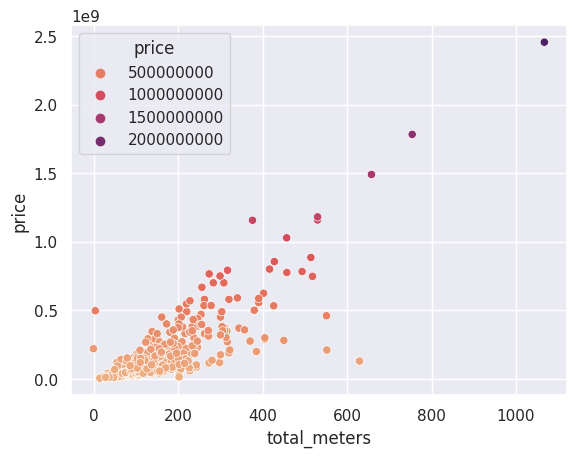

In [ ]:
sns.scatterplot(data=df, x="total_meters", y="price", hue='price', palette='flare')
plt.show()

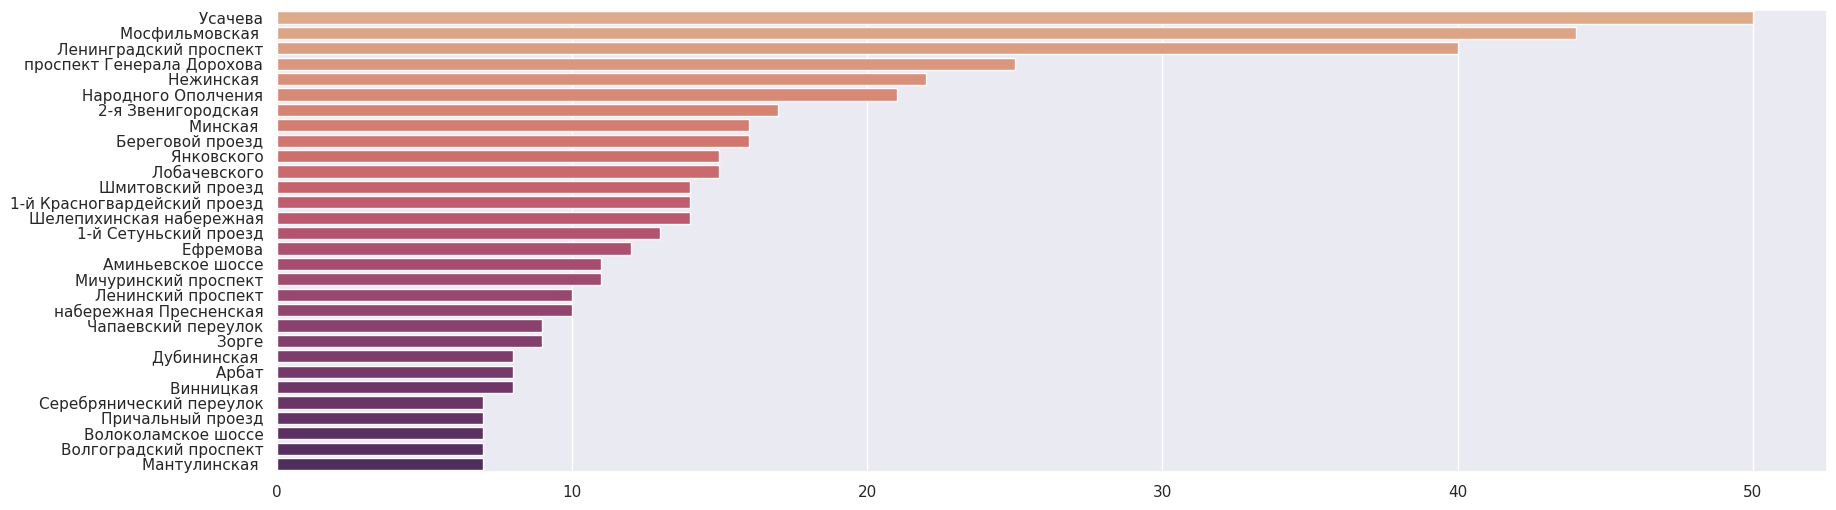

In [ ]:
from collections import Counter
from itertools import islice

location_count = Counter(df['street'])
out = {}
location_count = dict(location_count.most_common(30))
out.update(dict(islice(location_count.items(), 30)))
keys, values = zip(*out.items())
plt.figure(figsize=(20,6))
sns.barplot(y=np.array(keys), x=np.array(values), palette='flare')
plt.show()

In [ ]:
import geopandas as gpd

In [ ]:
geodata = gpd.read_file('mo.geojson')

In [ ]:
geodata = geodata[['NAME', 'geometry']]
prices_mean = df.groupby('district')['price'].mean()
df_price = pd.DataFrame(prices_mean)
df_price = df_price.reset_index()
geodata = geodata.rename(columns={"NAME": 'district'})

price_map = geodata.set_index('district').join(df_price.set_index('district'))
price_map = price_map.reset_index()

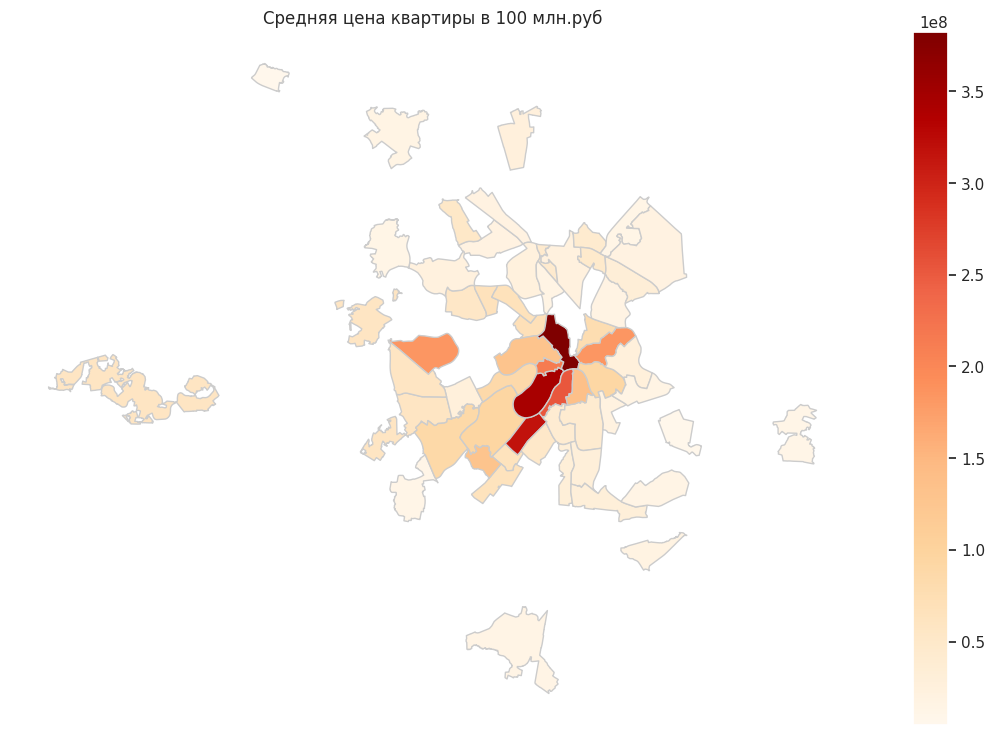

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 9))

price_map.plot(column= 'price',
               cmap='OrRd',
               linewidth=1,
               ax=ax,
               edgecolor='0.8',
               legend=True,
               legend_kwds={'orientation': "vertical"},
                )
ax.axis('off')
plt.title('Cредняя цена квартиры в 100 млн.руб')
plt.show()

Index(['Тверской', 'Хамовники', 'Гагаринский', 'Якиманка', 'Арбат',
       'Крылатское', 'Басманный', 'Замоскворечье', 'Пресненский',
       'Проспект Вернадского'],
      dtype='object', name='district')


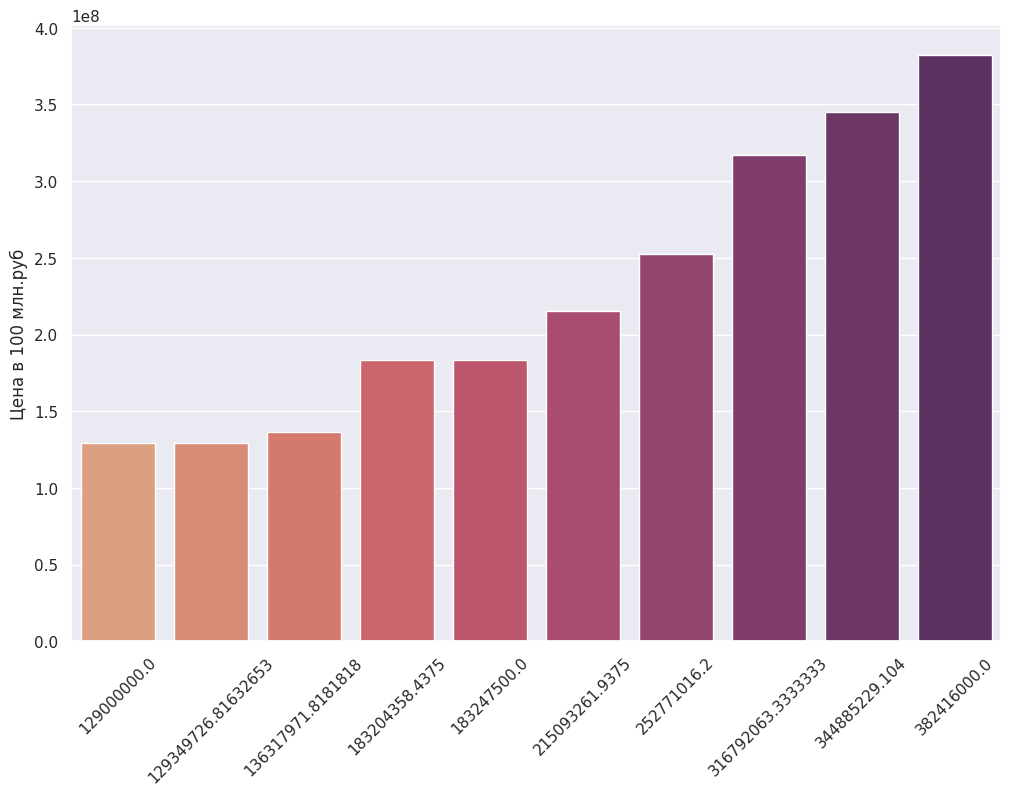

In [ ]:
area_counts = prices_mean.nlargest(10)
print(area_counts.keys())
plt.figure(figsize=(12,8))
sns.barplot(data=area_counts, y=list(area_counts.keys()), x=area_counts.values,  palette='flare')
plt.xticks(rotation=45)
plt.ylabel('Цена в 100 млн.руб')
plt.show()

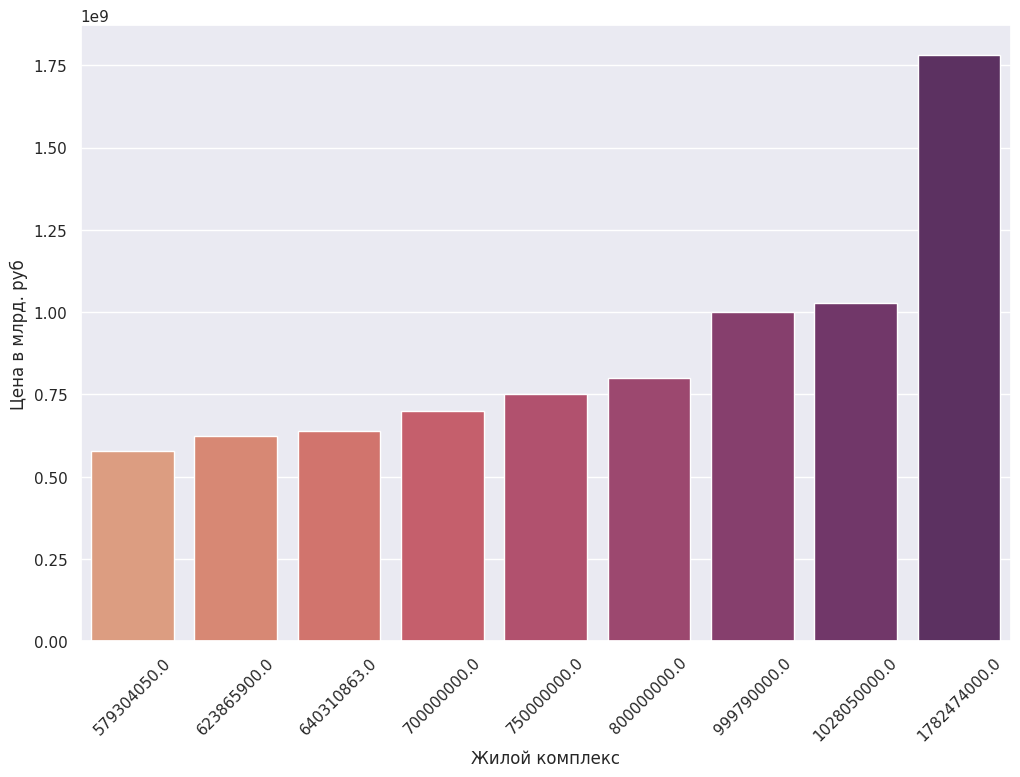

In [ ]:
complex_prices = df.groupby('residential_complex')['price'].mean()
complex_counts = complex_prices.nlargest(10)
plt.figure(figsize=(12,8))
sns.barplot(complex_counts, x=complex_counts.keys(), y=complex_counts.values, palette='flare')
plt.xticks(rotation=45)
plt.ylabel('Цена в млрд. руб')
plt.xlabel('Жилой комплекс')
plt.show()

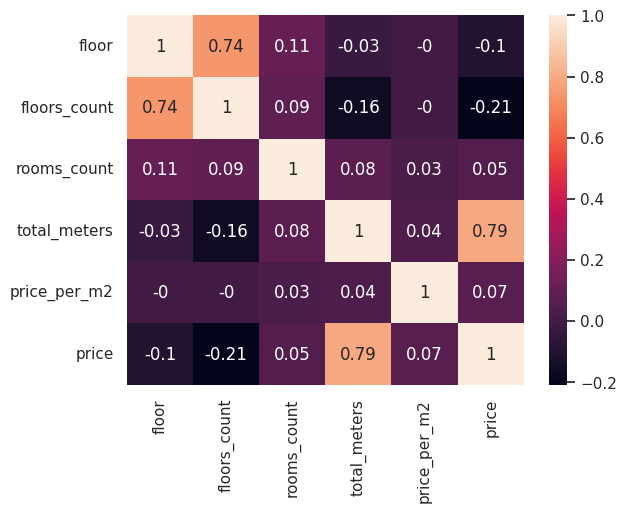

In [ ]:
from sklearn.preprocessing import LabelEncoder
df = df.drop(['author', 'author_type', 'link', 'city', 'deal_type', 'accommodation_type', 'house_number'],  axis=1)
le = LabelEncoder()
corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
x, y = df.drop('price', axis=1), df['price']

categorical = list(x.dtypes[x.dtypes == 'object'].index)
x[categorical] = x[categorical].fillna('NotGiven')
x[categorical].sample(20)

# polynom_converter = PolynomialFeatures(degree=3, include_bias=False)
# poly_features = polynom_converter.fit_transform(x)
# X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

,district,street,underground,residential_complex
847,Замоскворечье,Садовническая,Новокузнецкая,BALCHUG RESIDENCE
1027,Люблино,проезд Проектируемый № 8197,Братиславская,Светлый мир Станция Л
236,Дорогомилово,1-й Можайский тупик,Киевская,D'ORO MILLE
243,Хорошево-Мневники,Народного Ополчения,Народное Ополчение,Wellton Towers
1464,NotGiven,Жемчужная,Филатов Луг,Марьино Град
525,Хамовники,Молочный переулок,Парк Культуры,NotGiven
26,Пресненский,Краснопресненская набережная,Выставочная,Дом Дау
902,Фили-Давыдково,Кастанаевская,Кунцевская,NotGiven
1294,Замоскворечье,Садовническая набережная,Третьяковская,BALCHUG VIEWPOINT
191,Хамовники,Трубецкая,Фрунзенская,Садовые кварталы


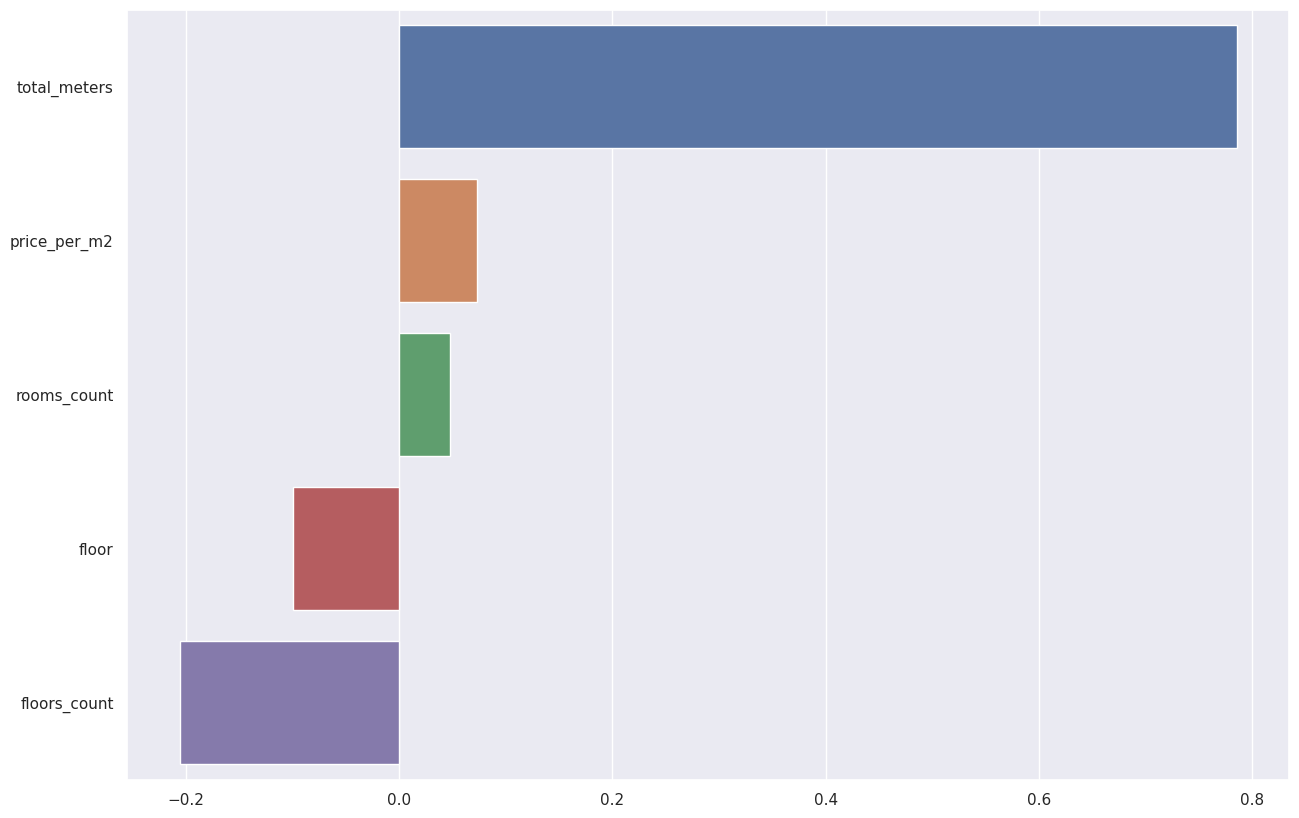

In [ ]:
numeric_data = x.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

x = x.fillna(numeric_data_mean)

corrs = x[numeric_features].corrwith(y).sort_values(ascending=False)

plot = sns.barplot(x=corrs, y=corrs.index)
plot.figure.set_size_inches(15, 10)

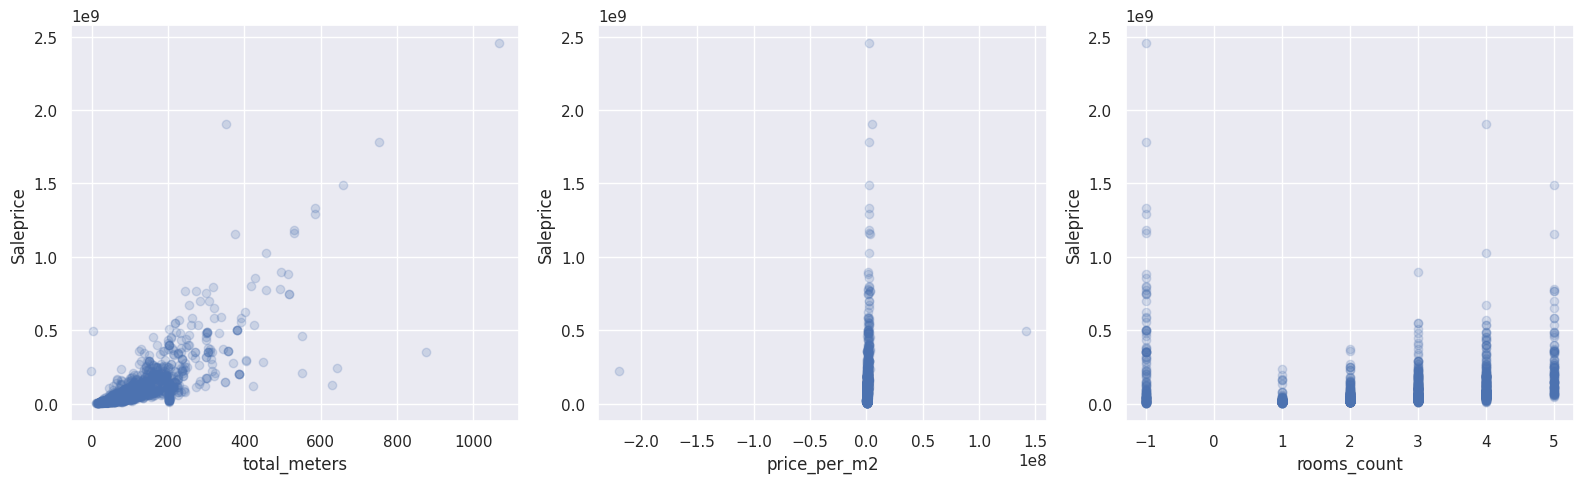

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['total_meters', 'price_per_m2', 'rooms_count']):
  axs[i].scatter(x[feature], y, alpha=0.2)
  axs[i].set_xlabel(feature)
  axs[i].set_ylabel('Saleprice')
plt.tight_layout()

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=10)
x_train, x_test = X_train, X_test

scaler = StandardScaler()
x_test = scaler.fit_transform(X_test[numeric_features])
x_train = scaler.fit_transform(X_train[numeric_features])
model = Ridge()
model.fit(x_train, Y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

print('Test RMSE %.4f' % mean_squared_error(Y_test, y_pred, squared=False))
print('Train RMSE %.4f' % mean_squared_error(Y_train, y_train_pred, squared=False))

Test RMSE 99424563.0289
Train RMSE 110125397.9948


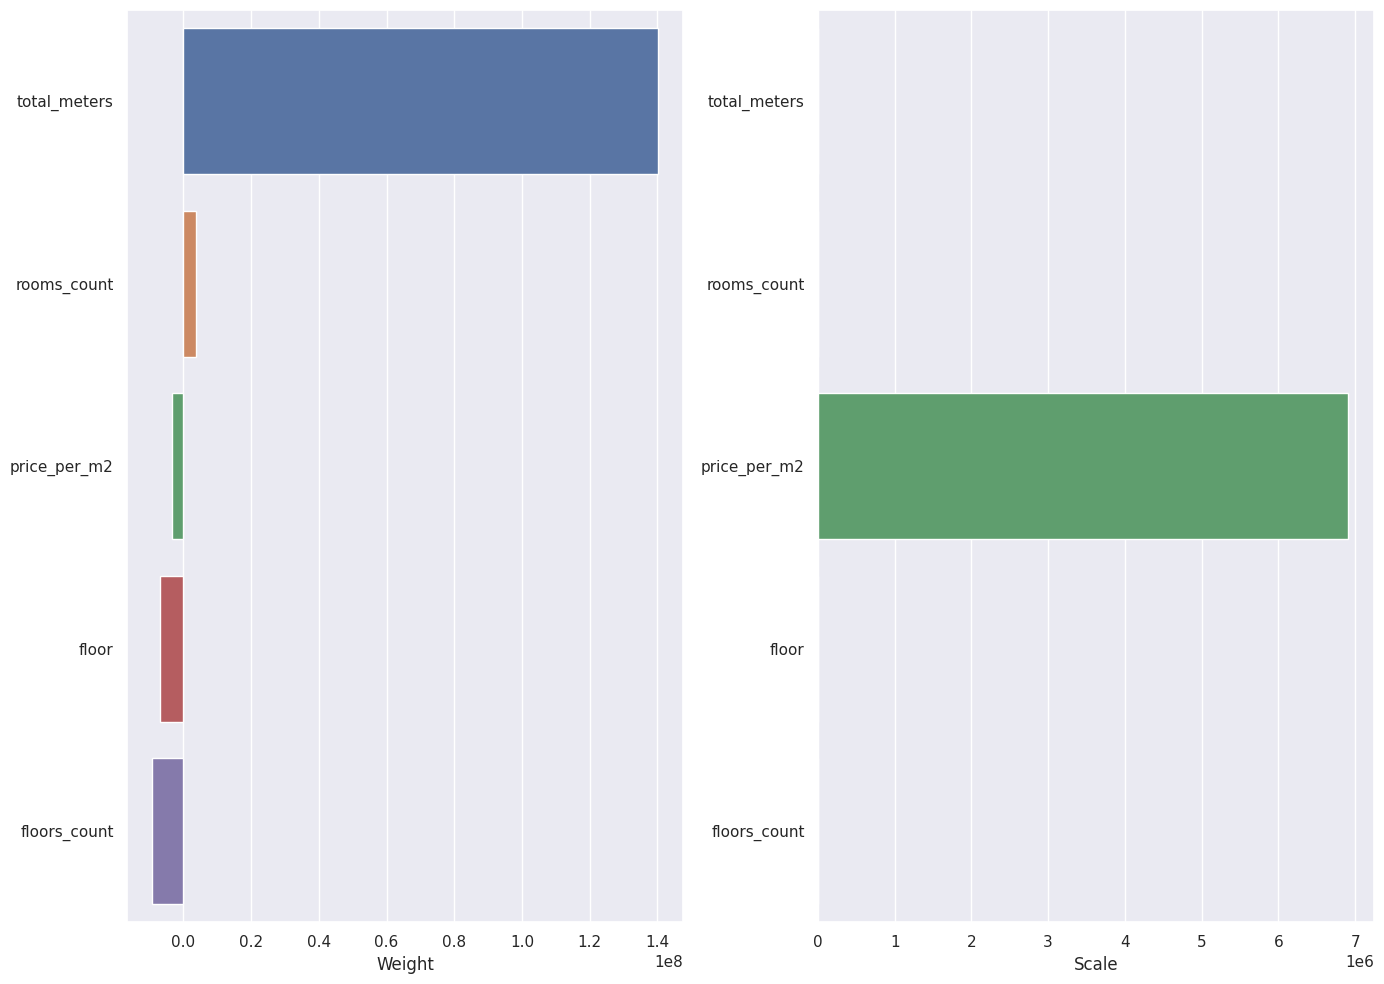

In [ ]:

def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()
scales = pd.Series(data=X_train.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Best alpha 0.5298
Best alpha 1000.0000
Best alpha 137.3824


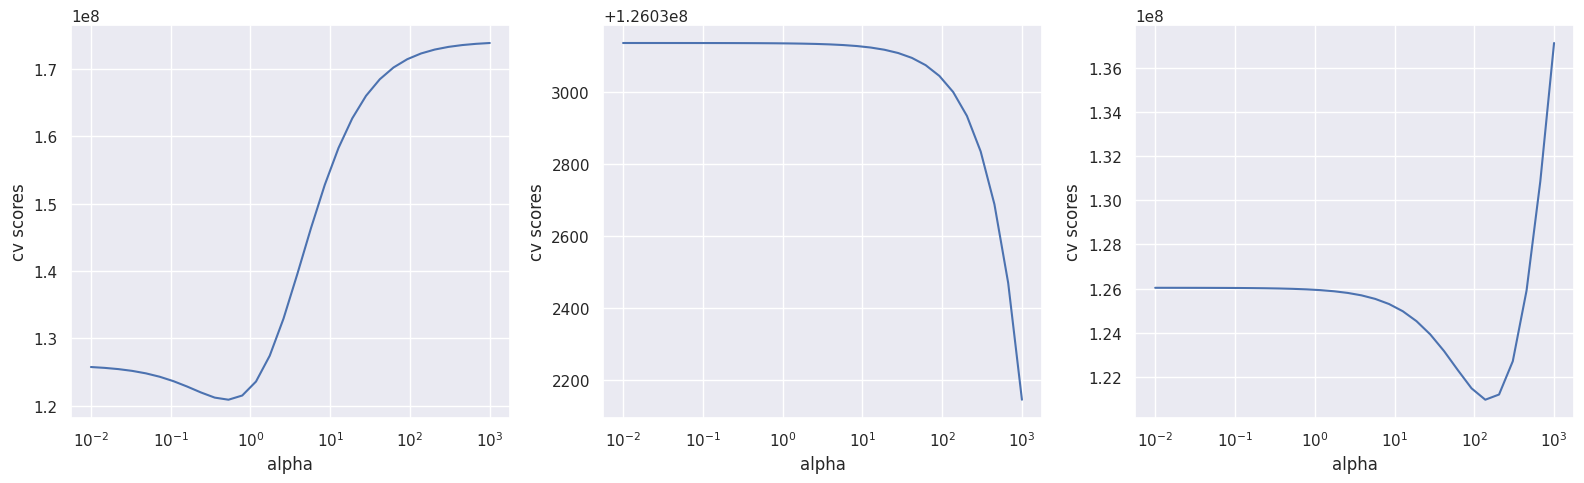

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

models_list = [ElasticNet(), Lasso(), Ridge()]
best_alphas = []
alphas = np.logspace(-2, 3, 30)
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, model_ in enumerate(models_list):
  searcher = GridSearchCV(model_, [{'alpha': alphas}], scoring='neg_root_mean_squared_error', cv=10)
  searcher.fit(X_train, Y_train)
  best_alpha = searcher.best_params_['alpha']
  print('Best alpha %.4f' % best_alpha)
  best_alphas.append(best_alpha)

  axs[i].plot(alphas, -searcher.cv_results_['mean_test_score'])
  axs[i].set_xscale('log')
  axs[i].set_xlabel('alpha')
  axs[i].set_ylabel('cv scores')
plt.tight_layout()

In [ ]:
column_transformer = ColumnTransformer(
    [
        ('scaling', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)

    ]
)

pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

pipeline_elastic = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', ElasticNet())
])
pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])


for i, m in enumerate([pipeline_elastic, pipeline_lasso, pipeline_ridge]):
  model = m.fit(x_train, Y_train)
  y_pred = model.predict(x_test)
  print('Test RMSE %.4f' % mean_squared_error(Y_test, y_pred, squared=False))

Test RMSE 97619107.2251
Test RMSE 116697852.1970
Test RMSE 85315394.0387


Best alpha 204.3360
Best alpha 1000.0000
Best alpha 1000.0000


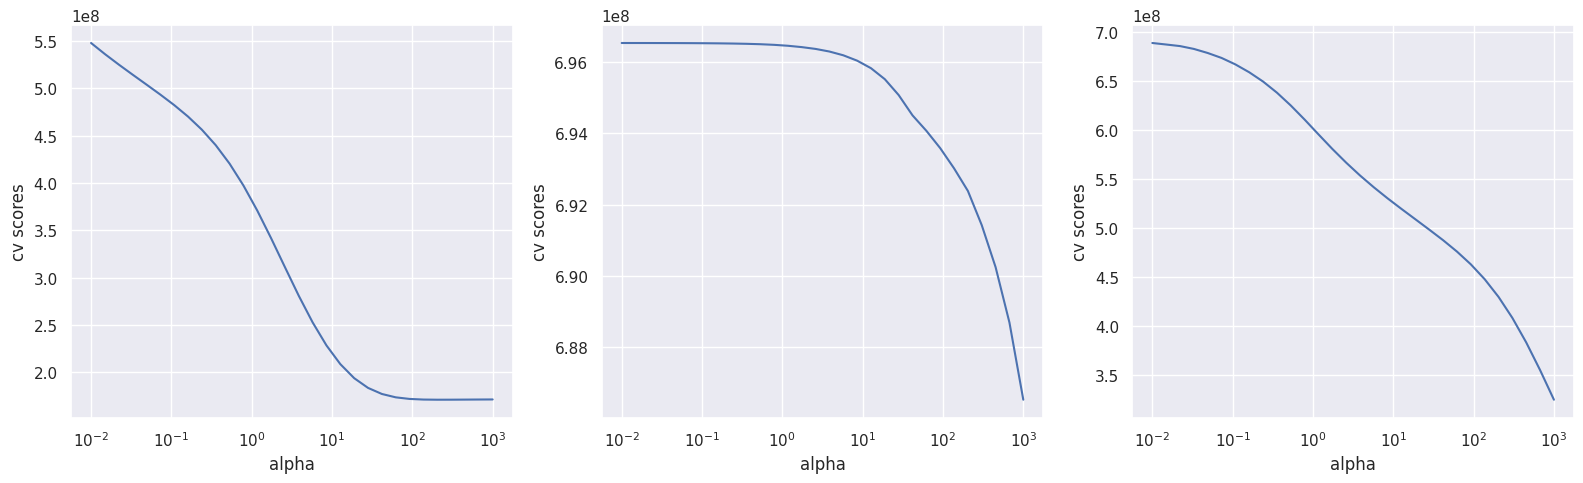

In [ ]:
pipelines = [pipeline_elastic, pipeline_lasso, pipeline_ridge]
best_alphas_pipe = []
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, model_ in enumerate(pipelines):
  searcher = GridSearchCV(model_, [{'regression__alpha': alphas}], scoring='neg_root_mean_squared_error', cv=10)
  searcher.fit(x_train, Y_train)
  best_alpha = searcher.best_params_['regression__alpha']
  print('Best alpha %.4f' % best_alpha)
  best_alphas_pipe.append(best_alpha)

  axs[i].plot(alphas, -searcher.cv_results_['mean_test_score'])
  axs[i].set_xscale('log')
  axs[i].set_xlabel('alpha')
  axs[i].set_ylabel('cv scores')
plt.tight_layout()

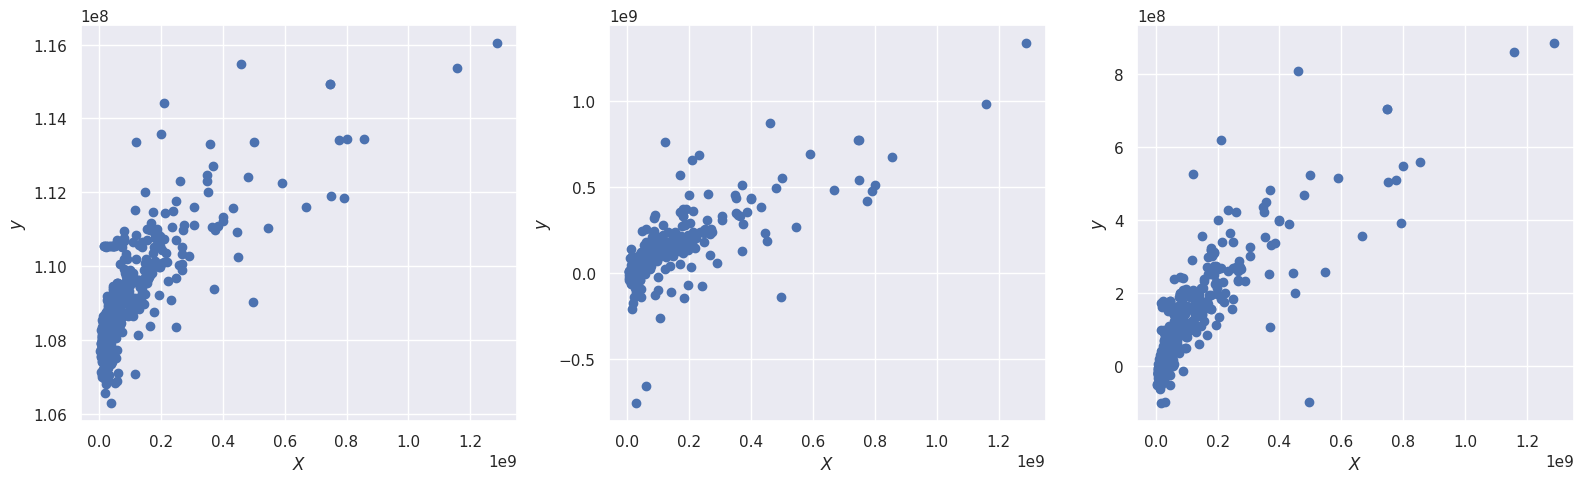

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
pipelines = [pipeline_elastic, pipeline_lasso, pipeline_ridge]
best_alphas_pipe = [0.0100, 303.9195, 8.5317]
models_list = [ElasticNet(), Lasso(), Ridge()]
for i, m in enumerate(pipelines):
  model = m.fit(x_train, Y_train)
  y_pred = model.predict(x_test)
  axs[i].scatter(Y_test, y_pred, label="Data")
  axs[i].set_xlabel("$X$")
  axs[i].set_ylabel("$y$")
plt.tight_layout()

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor

pipeline_xg = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', XGBRegressor(
        n_estimators=1000, learning_rate=0.05, n_jobs=4
        ))
])

pipeline_xg.fit(x_train, Y_train)
y_pred_xg = pipeline_xg.predict(x_test)

r2_xgboost = r2_score(Y_test, y_pred_xg)

pipeline_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alphas_pipe[2]))
])

pipeline_elastic = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', ElasticNet(best_alphas_pipe[0]))
])
pipeline_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alphas_pipe[1]))
])

model_elastic = pipeline_elastic
model_elastic.fit(x_train, Y_train)
y_pred_net = model_elastic.predict(x_test)

model_lasso = pipeline_lasso
model_lasso.fit(x_train, Y_train)
y_pred_lasso = model_lasso.predict(x_test)

model_ridge = pipeline_ridge
model_ridge.fit(x_train, Y_train)
y_pred = model_ridge.predict(x_test)

r2_net = r2_score(Y_test, y_pred_net)
r2_lasso = r2_score(Y_test, y_pred_lasso)
r2_ridge = r2_score(Y_test, y_pred)
print("R^2 score for Neural Network WITH ElasticNetCV: ", r2_net)
print("R^2 score for Neural Network WITH Lasso: ", r2_lasso)
print("R^2 score for Neural Network WITH Ridge: ", r2_ridge)
print("R^2 score for Neural Network WITH XGBRegressor: ", r2_xgboost)
print(max([r2_net, r2_lasso, r2_ridge, r2_xgboost]))

R^2 score for Neural Network WITH ElasticNetCV:  0.7015166938958823
R^2 score for Neural Network WITH Lasso:  0.4703040830787979
R^2 score for Neural Network WITH Ridge:  0.6954653982690089
R^2 score for Neural Network WITH XGBRegressor:  0.9277950712011558
0.9277950712011558
